In this notebook, some text feature is introduced. And i will give some insight and product method in shopee compte. If you find usefule, please give upvote, thx.

- Title edit distance
- TFIDF
- BM25
- Word2vec
- Bert

在本个notebook中，介绍了一些文本特征提取方法。我也会在介绍使用的同时，结合shopee比赛给出一些建议。如果你感谢内容对你有帮助，请给我点赞，谢谢。


You can check my other notebooks:

- [Shopee Products Matching: Image Part [English+中文]](https://www.kaggle.com/finlay/shopee-products-matching-image-part-english)
- [Shopee Products Matching: Text Part [English+中文]](https://www.kaggle.com/finlay/shopee-products-matching-text-part-english)
- [Shopee Products Matching: BoF Part [English+中文]](https://www.kaggle.com/finlay/shopee-products-matching-bof-part-english)
- [Shopee Products Matching: Augment Part [English中文]](https://www.kaggle.com/finlay/shopee-products-matching-augment-part-english)
- [[Unsupervised] Image + Text Baseline in 20min](https://www.kaggle.com/finlay/unsupervised-image-text-baseline-in-20min)

In [ ]:
DATA_PATH = '../input/shopee-product-matching/'

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2, matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import gc

# f1 score metric
def getMetric(col):
    def f1score(row):
        n = len( np.intersect1d(row.target,row[col]) )
        return 2*n / (len(row.target)+len(row[col]))
    return f1score

train = pd.read_csv(DATA_PATH + 'train.csv')
train['image'] = DATA_PATH + 'train_images/' + train['image']
tmp = train.groupby('label_group').posting_id.agg('unique').to_dict()
train['target'] = train.label_group.map(tmp)

In [ ]:
train = train.sort_values(by='label_group')
train['title'] = train['title'].str.lower()
train.head()

# Title Edit Distance

Edit distance is a way of quantifying how dissimilar two strings (e.g., words) are to one another by counting the minimum number of operations required to transform one string into the other.

字符编辑距离可用衡量标题的距离。在这里可以直接计算两个商品的标题共同包含了多少个单词。

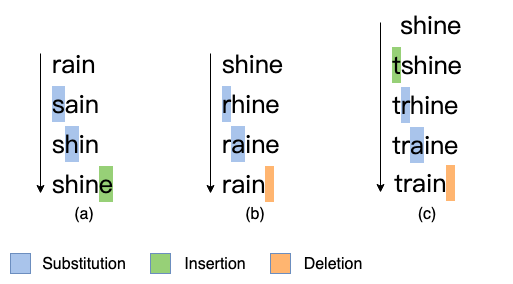

https://stackoverflow.com/questions/2460177/edit-distance-in-python

In shopee, you can find product in same group may have common word, so we can count the intersect words count.

In [ ]:
def title_share_distance(s1, s2):
    s1_word = set(s1.split(' '))
    s2_word = set(s2.split(' '))
    return 1 - len((s1_word.intersection(s2_word))) / len(s1_word.union(s2_word))

In [ ]:
# same group
title_share_distance(train['title'].iloc[0], train['title'].iloc[1])

In [ ]:
# same group
title_share_distance(train['title'].iloc[0], train['title'].iloc[2])

In [ ]:
# different group
title_share_distance(train['title'].iloc[0], train['title'].iloc[1000])

In [ ]:
# different group
title_share_distance(train['title'].iloc[0], train['title'].iloc[2000])

# TFIDF

The tf–idf is the product of two statistics, term frequency and inverse document frequency. There are various ways for determining the exact values of both statistics. 

TFIDF contains two parts: TF(term frequency) and IDF(inverse document frequency).
* TF is the word count in each sentence.
* IDF is the importance of each word.

TFIDF是非常有效的，TF计算了词频，IDF计算了词的重要性。

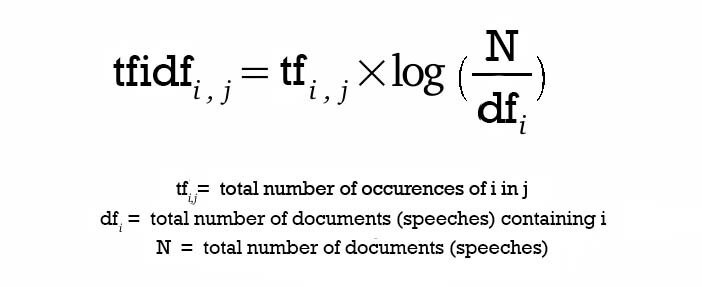

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html


TFIDF can count single word or two-word/three-word together, in shopee compte single word is good and memory effectient.

TFIDF 可以计算1-gram，2-gram，但在shopee题目中1-gram足够。

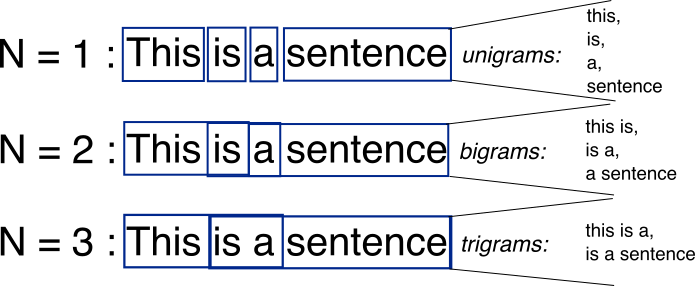

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = [
    'This is the first document.',
    'This document is the second document.',
    'And this is the third one.',
    'Is this the first document?',
]
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X = vectorizer.fit_transform(corpus)
print(vectorizer.get_feature_names())

print(X.shape)

In [ ]:
model = TfidfVectorizer(stop_words=None, binary=True, max_features=55000)
text_embeddings = model.fit_transform(train.title).toarray()
print('text embeddings shape',text_embeddings.shape)

In [ ]:
import torch
text_embeddings = torch.from_numpy(text_embeddings)
text_embeddings = text_embeddings.cuda()

In [ ]:
preds = []
CHUNK = 1024*2

print('Finding similar titles...')
CTS = len(train)//CHUNK
if len(train)%CHUNK!=0: CTS += 1
text_ids = None
    
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(train))
    print('chunk',a,'to',b)
    
    cts = torch.matmul(text_embeddings, text_embeddings[a:b].T).T
    cts = cts.data.cpu().numpy()
    for k in range(b-a):
        IDX = np.where(cts[k,]>0.6)[0]
        o = train.iloc[IDX].posting_id.values
        preds.append(o)
        
    del cts
    torch.cuda.empty_cache()

In [ ]:
del text_embeddings
torch.cuda.empty_cache()

train['oof_text'] = preds

we can also omit the top fraq word.

In [ ]:
from collections import Counter
word_counter = Counter(' '.join(train['title'].values).split(' '))
most_occur = pd.DataFrame({'word': word_counter.keys(), 'count': word_counter.values()})
most_occur = most_occur[most_occur['word'].apply(len) > 1]

most_occur = most_occur.sort_values(by='count', ascending=False)
most_occur.head(10)

# BM25

Okapi BM25 (BM is an abbreviation of best matching) is a ranking function used by search engines to estimate the relevance of documents to a given search query.

BM25 improves upon TF*IDF. BM25 stands for “Best Match 25”. Released in 1994, it’s the 25th iteration of tweaking the relevance computation. BM25 has its roots in probabilistic information retrieval. 

BM25是对TFIDF的改进，在精度上有一定提高。

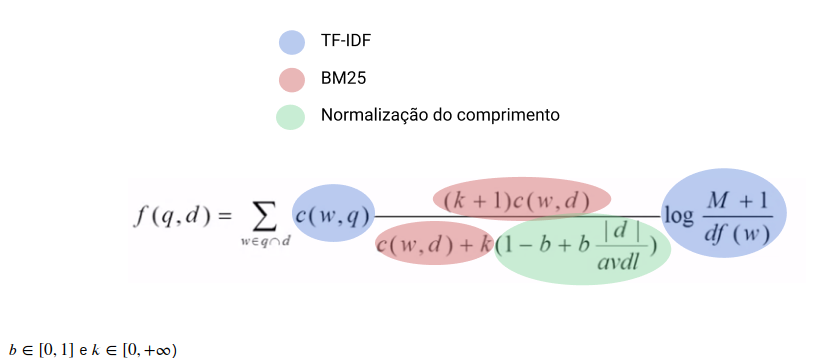

https://github.com/dorianbrown/rank_bm25
https://www.kaggle.com/ideanlabib/bm25-search-query-similarity-ranking/
https://gist.github.com/koreyou/f3a8a0470d32aa56b32f198f49a9f2b8

In [ ]:
!pip install rank_bm25

In [ ]:
from rank_bm25 import BM25Okapi
from nltk.tokenize import word_tokenize
train_title_token = train['title'].apply(lambda x: word_tokenize(x))

In [ ]:
bm25 = BM25Okapi(train_title_token)

In [ ]:
ids = bm25.get_scores(train_title_token.iloc[200])
idx = np.where(ids>50)[0]
print(ids[idx])
train.iloc[idx]

In [ ]:
ids = bm25.get_scores(train_title_token.iloc[1000])
idx = np.where(ids>50)[0]
print(ids[idx])
train.iloc[idx]

# Word2Vec

Word embedding capable of capturing context of a word in a document, semantic and syntactic similarity, relation with other words, etc.

Word2Vec is one of the most popular technique to learn word embeddings using shallow neural network. Word2vec represents each distinct word with a particular list of numbers called a vector. The vectors are chosen carefully such that a simple mathematical function (the cosine similarity between the vectors) indicates the level of semantic similarity between the words represented by those vectors.

词向量可以将单词映射到向量空间，相似的相似映射后距离相近，我们也可以借助预训练好词向量来完成title 相似度计算。

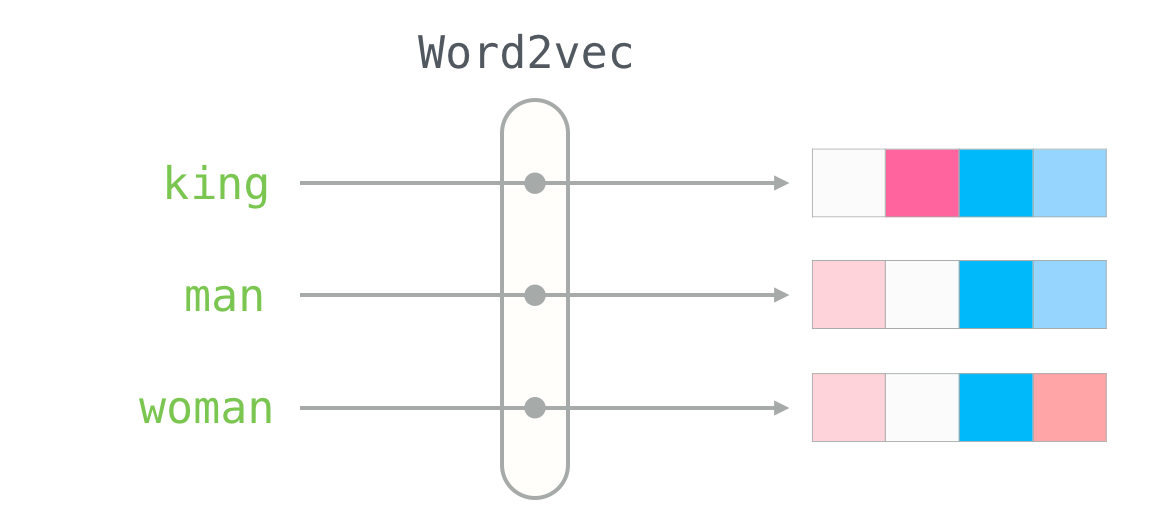

* https://en.wikipedia.org/wiki/Word2vec
* https://towardsdatascience.com/introduction-to-word-embedding-and-word2vec-652d0c2060fa

In [ ]:
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors

vectors = KeyedVectors.load_word2vec_format("../input/glove2word2vec/glove_w2v.txt") # import the data file

In [ ]:
text_embeddings = []
for title in tqdm_notebook(train_title_token[:]):
    title_feat = []
    for word in title:
        if word in vectors:
            title_feat.append(vectors[word])
    
    if len(title_feat) == 0:
        title_feat = np.random.rand(200)
    else:
        # max-pooling
        # mean-pooling
        # IDF
        # SIF
        title_feat = np.vstack(title_feat).max(0)
    text_embeddings.append(title_feat)
    # break

In [ ]:
from sklearn.preprocessing import normalize

# l2 norm to kill all the sim in 0-1
text_embeddings = np.vstack(text_embeddings)
text_embeddings = normalize(text_embeddings)

import torch
text_embeddings = torch.from_numpy(text_embeddings)
text_embeddings = text_embeddings.cuda()


In [ ]:
preds = []
CHUNK = 1024*4


print('Finding similar images...')
CTS = len(text_embeddings)//CHUNK
if len(text_embeddings)%CHUNK!=0: CTS += 1
for j in range( CTS ):
    
    a = j*CHUNK
    b = (j+1)*CHUNK
    b = min(b,len(train))
    print('chunk',a,'to',b)
    
    cts = torch.matmul(text_embeddings, text_embeddings[a:b].T).T
    cts = cts.data.cpu().numpy()
    for k in range(b-a):
        IDX = np.where(cts[k,]>0.93)[0]
        o = train.iloc[IDX].posting_id.values
        preds.append(o)
        
    del cts
    torch.cuda.empty_cache()

In [ ]:
train['oof_w2v'] = preds

## Train Your Own Word2Vec

we can train word2vec on shopee dataset.

* https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
* https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=common_texts, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [ ]:
common_texts

In [ ]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

model = Word2Vec(sentences=train_title_token, vector_size=200, window=5, min_count=1, workers=4)
model.save("word2vec.model")

# Bert

Bidirectional Encoder Representations from Transformers (BERT) is a Transformer-based machine learning technique for natural language processing (NLP) pre-training developed by Google.

we can finetune bert on Next Sentense Prediction (NSP) task, try to match two product by title.
* first construct title pair (match or not match)
* load bert model
* define loss and train

Bert模型非常强大，且可以用于文本匹配任务。如果使用文本匹配的思路，则需要构建匹配训练集，然后定义模型并训练。

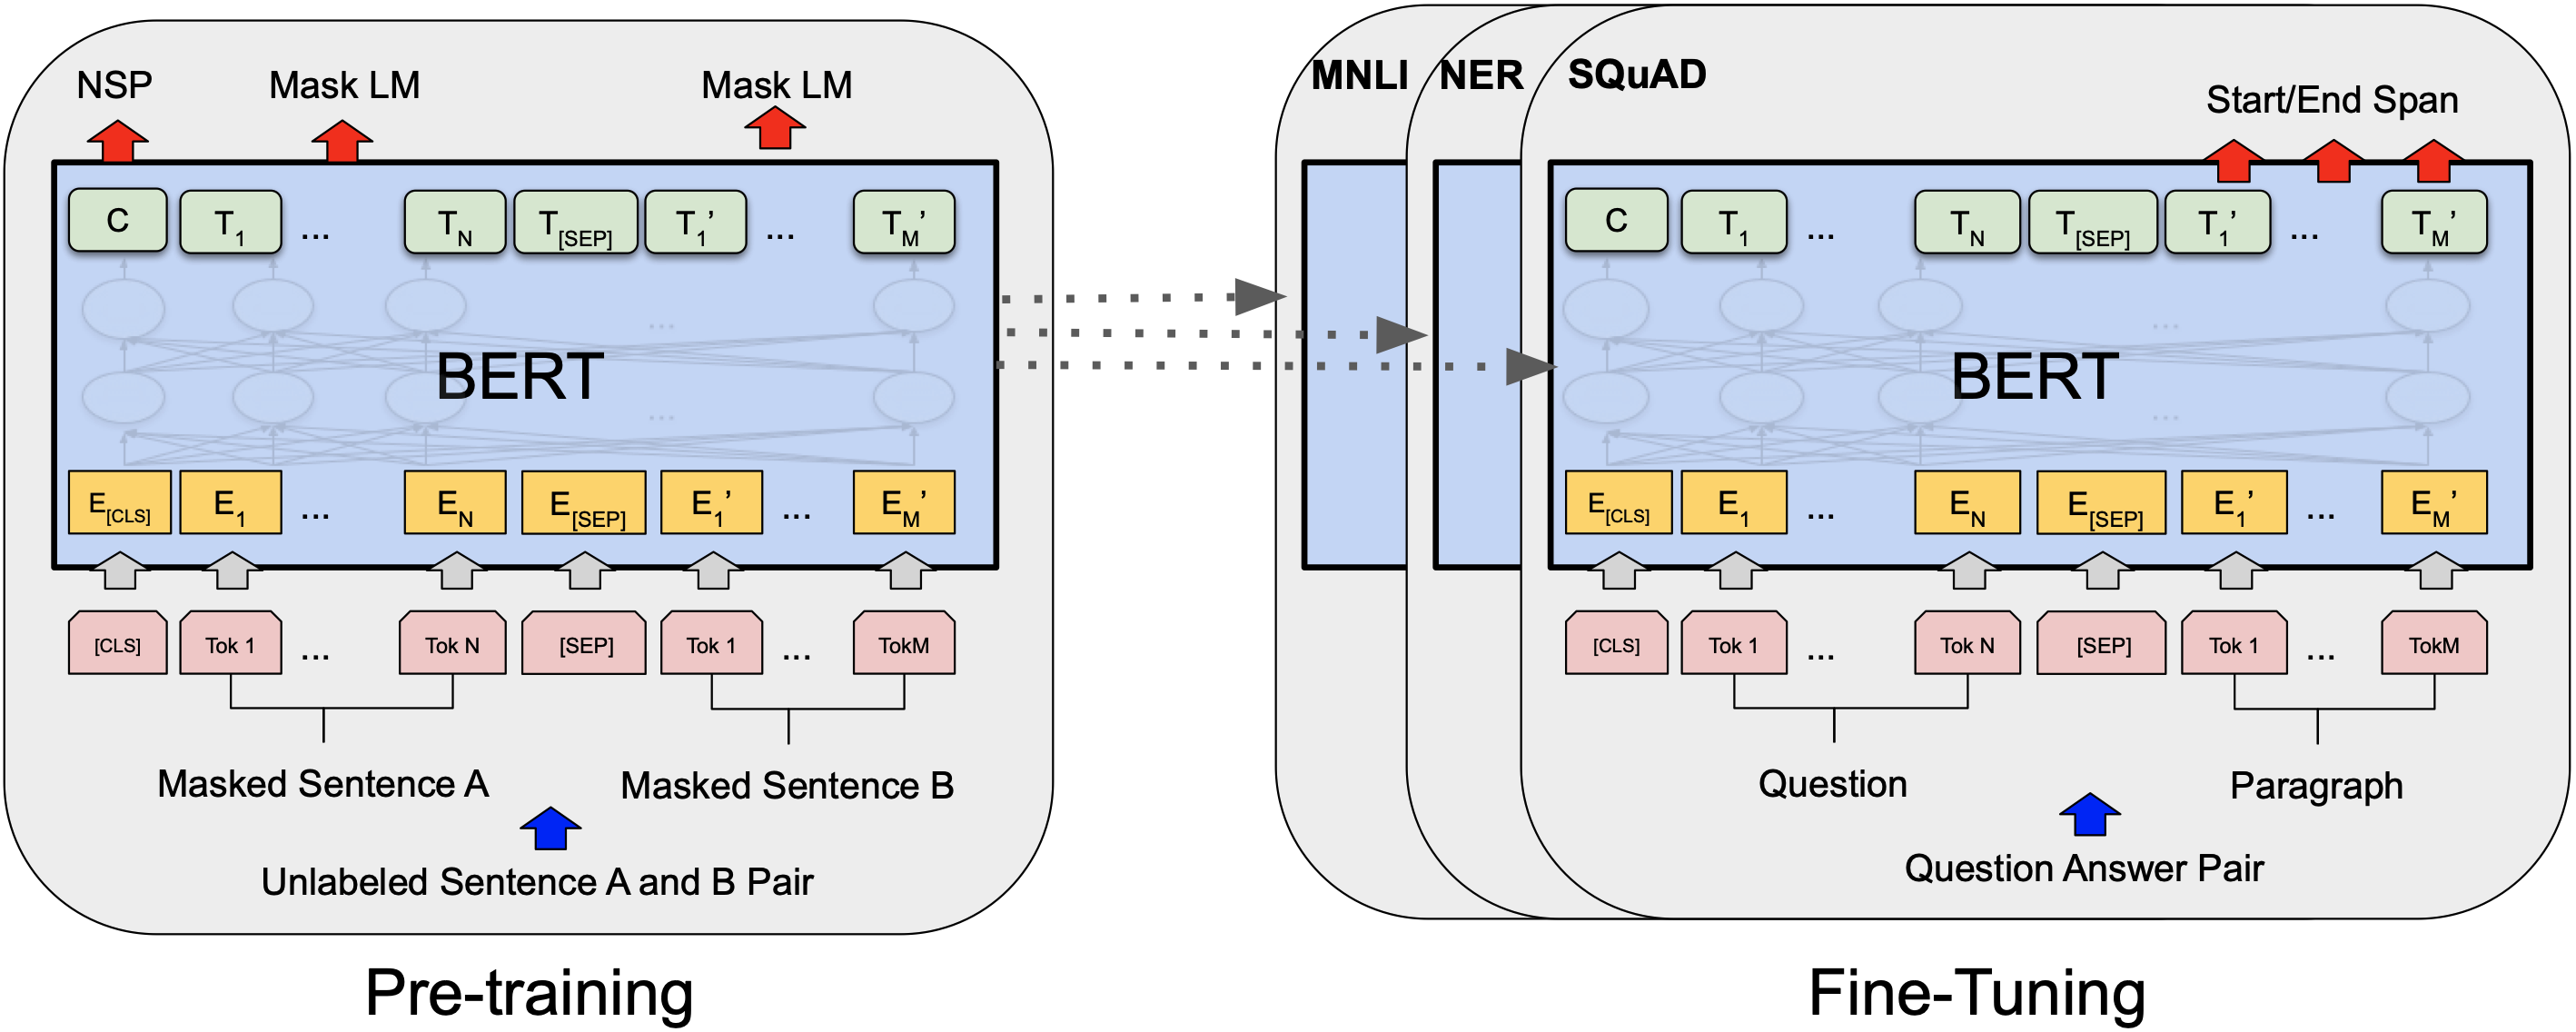

https://en.wikipedia.org/wiki/BERT_(language_model)

In [ ]:
def combine_for_oof(row):
    x = np.concatenate([row.oof_text,row.oof_w2v])
    return np.unique(x)

# merge product proposal by tfidf and word2vec, we have positive and negative example.
# if two product in same group they are positive label.
train['oof'] = train.apply(combine_for_oof,axis=1)

In [ ]:
train = train.set_index('posting_id')

In [ ]:
title_pair = []
for row in tqdm_notebook(train.iterrows()):
    for pair in row[1].oof:
        # not match self
        if pair == row[0]:
            continue
    
        if pair in row[1].target:
            lbl = 1
        else:
            lbl = 0

        title_pair.append(
            [row[1].title, train.loc[pair]['title'], lbl]
        )

In [ ]:
title_pair = pd.DataFrame(title_pair, columns=['s1', 's2', 'label'])
title_pair = title_pair.sample(frac=1)
title_pair.head(5)

In [ ]:
train_pair = title_pair.iloc[:5000]
val_pair = title_pair.iloc[5000:6000]

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-cased", model_max_length=128)
sequence_a = "HuggingFace is based in NYC"
sequence_b = "Where is HuggingFace based?"
encoded_dict = tokenizer(sequence_a, sequence_a)
encoded_dict

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
import random
import re

class ShopeeTextDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, idx):
        item = tokenizer(self.df.iloc[idx]['s1'], self.df.iloc[idx]['s2'], 
                         truncation=True, padding='max_length',  max_length=128)
        item = {key: torch.tensor(val) for key, val in item.items()}
        item['labels'] = torch.tensor(self.df.iloc[idx]['label'])
        return item
    
    def __len__(self):
        return self.df.shape[0]

In [ ]:
from transformers import BertForSequenceClassification, AdamW
model = BertForSequenceClassification.from_pretrained('bert-base-cased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
optim = AdamW(model.parameters(), lr=2e-5)
train_dataset = ShopeeTextDataset(train_pair)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

val_dataset = ShopeeTextDataset(val_pair)
val_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [ ]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def train():
    model.train()
    total_train_loss = 0
    iter_num = 0
    total_iter = len(train_loader)
    for batch in train_loader:
        optim.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs[0]
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optim.step()

        iter_num += 1
        if(iter_num % 100==0):
            print("epoth: %d, iter_num: %d, loss: %.4f, %.2f%%" % (epoch, iter_num, loss.item(), iter_num/total_iter*100))
        
    print("Epoch: %d, Average training loss: %.4f"%(epoch, total_train_loss/len(train_loader)))
    
def validation():
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    for batch in tqdm_notebook(val_loader):
        with torch.no_grad():
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        
        loss = outputs[0]
        logits = outputs[1]

        total_eval_loss += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("Accuracy: %.4f" % (avg_val_accuracy))
    print("Average testing loss: %.4f"%(total_eval_loss/len(val_loader)))
    print("-------------------------------")

In [ ]:
for epoch in range(3):
    print("------------Epoch: %d ----------------" % epoch)
    train()
    validation()

# Conclusion & Advice

1. BM25 is more effective than TFIDF, but it's a litter slow.
2. use title embedding in word2vec to find similar product maybe not a good idea.
3. we can use bert to rank the product:
    * first search product by cnn feature
    * then match the product by bert title model.
4. try sentence-bet.